In [1]:
from copy import deepcopy

import k3d
import yaml
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm
import json

from scipy.interpolate import interp1d

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-fu9beblj because the default path (/home/user/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [17]:
def get_func_values(n_points):
    n_segments = n_points + 1
    
    x_i = np.cumsum(np.random.exponential(size=n_points))
    x_i /= (x_i[-1] + 1)
    x_i = np.concatenate(([0.], x_i, [1.]))
    
    y_i = np.random.uniform(size=n_points + 2)
    
    orders = np.random.randint(1, 4, size=n_segments)

    func_x = np.linspace(0, 1, 1001)
    func_values = []

    kind_by_order = {
        1: 'linear',
        2: 'quadratic',
        3: 'cubic'
    }

    for i, order in enumerate(orders):
        x_left, x_right = x_i[i], x_i[i + 1]
        y_left, y_right = y_i[i], y_i[i + 1]

        interp_x = np.random.uniform(size=order - 1) if order > 1 else []
        interp_y = np.random.uniform(size=order - 1)

        x = np.concatenate((
            [x_left], interp_x, [x_right]
        ))
        y = np.concatenate((
            [y_left], interp_y, [y_right]
        ))

        f = interp1d(x, y, kind=kind_by_order[order])

        x_segment = func_x[(func_x >= x_left) & (func_x < x_right)]
        func_values.append((f, x_segment, f(x_segment)))

    return func_x, func_values, x_i, y_i

In [19]:
def get_discrete_func_values(
    func_x, 
    func_values,
    x_i, y_i,
    discrete_dx
):

    n_discrete_segments = int(1 / discrete_dx)
    discrete_x = np.linspace(0, 1, n_discrete_segments + 1)

    discrete_x = np.insert(
        discrete_x,
        np.searchsorted(discrete_x, x_i[1:-1]),
        x_i[1:-1]
    )
    n_discrete_segments = len(discrete_x) - 1

    discrete_func_values = []
    discrete_x_i, discrete_y_i = [], []
    for i in range(n_discrete_segments):
        x_left, x_right = discrete_x[i], discrete_x[i + 1]
        patch_idx = np.where(x_i <= x_left)[0][-1]

        x = np.array([x_left, x_right])
        f, _, _ = func_values[patch_idx]
        y = f(x)

        discrete_f = interp1d(x, y, kind='linear')

        x_segment = func_x[(func_x >= x_left) & (func_x < x_right)]
        discrete_func_values.append((discrete_f, x_segment, discrete_f(x_segment)))

        discrete_x_i.append(x[0])
        discrete_y_i.append(y[0])
        
    return discrete_func_values, discrete_x_i, discrete_y_i, discrete_x

In [20]:
def get_sampling(
    discrete_func_values,
    discrete_x,
    sampling_dx
):
    n_samples = int(1 / sampling_dx)
    # samples_x = np.random.uniform(size=n_samples)
    samples_x = np.linspace(sampling_dx, 1 - sampling_dx, n_samples)
    
    samples_y = []
    for i, sample in enumerate(samples_x):
        discrete_f_idx = np.where(discrete_x < sample)[0][-1]
        f = discrete_func_values[discrete_f_idx][0]
        samples_y.append(f(sample))
    samples_y = np.array(samples_y)
    
    return samples_x, samples_y

In [21]:
def plot_all(
    func_values,
    x_i, y_i,
    discrete_func_values,
    discrete_x_i, discrete_y_i,
    samples_x, samples_y
):
    fig, axs = plt.subplots(figsize=(16, 4*3), nrows=3)
    
    # plot continuous representations
    for i, (f, func_interp_x, func_interp_y) in enumerate(func_values):
        axs[0].plot(func_interp_x, func_interp_y, c='k', label='patch {}'.format(i))
    axs[0].scatter(x_i, y_i, c='r', s=100, label='patch boundaries')
    axs[0].legend(fontsize=14, loc='upper right', bbox_to_anchor=(1.15, 1.10))
    
    
    # plot discrete representations
    for i, (f, func_interp_x, func_interp_y) in enumerate(discrete_func_values):
        axs[1].plot(func_interp_x, func_interp_y, c='k', label='face {}'.format(i))
    axs[1].scatter(discrete_x_i, discrete_y_i, c='k', s=200, marker='|', label='edges')
    axs[1].scatter(x_i, y_i, c='r', s=100)
    axs[1].legend(fontsize=14, loc='upper right', bbox_to_anchor=(1.15, 1.10))
    
    # plot samples
    axs[2].scatter(samples_x, samples_y, c='k', s=20, label='samples')
    axs[2].legend(fontsize=14)


In [38]:
n_points = np.random.randint(1, 6)
func_x, func_values, x_i, y_i = get_func_values(n_points)

In [42]:
discrete_dx = 0.01

discrete_func_values, discrete_x_i, discrete_y_i, discrete_x = get_discrete_func_values(
    func_x, func_values,
    x_i, y_i,
    discrete_dx=discrete_dx
)

In [43]:
sampling_dx = 0.05 / 16

samples_x, samples_y = get_sampling(
    discrete_func_values,
    discrete_x,
    sampling_dx=sampling_dx
)

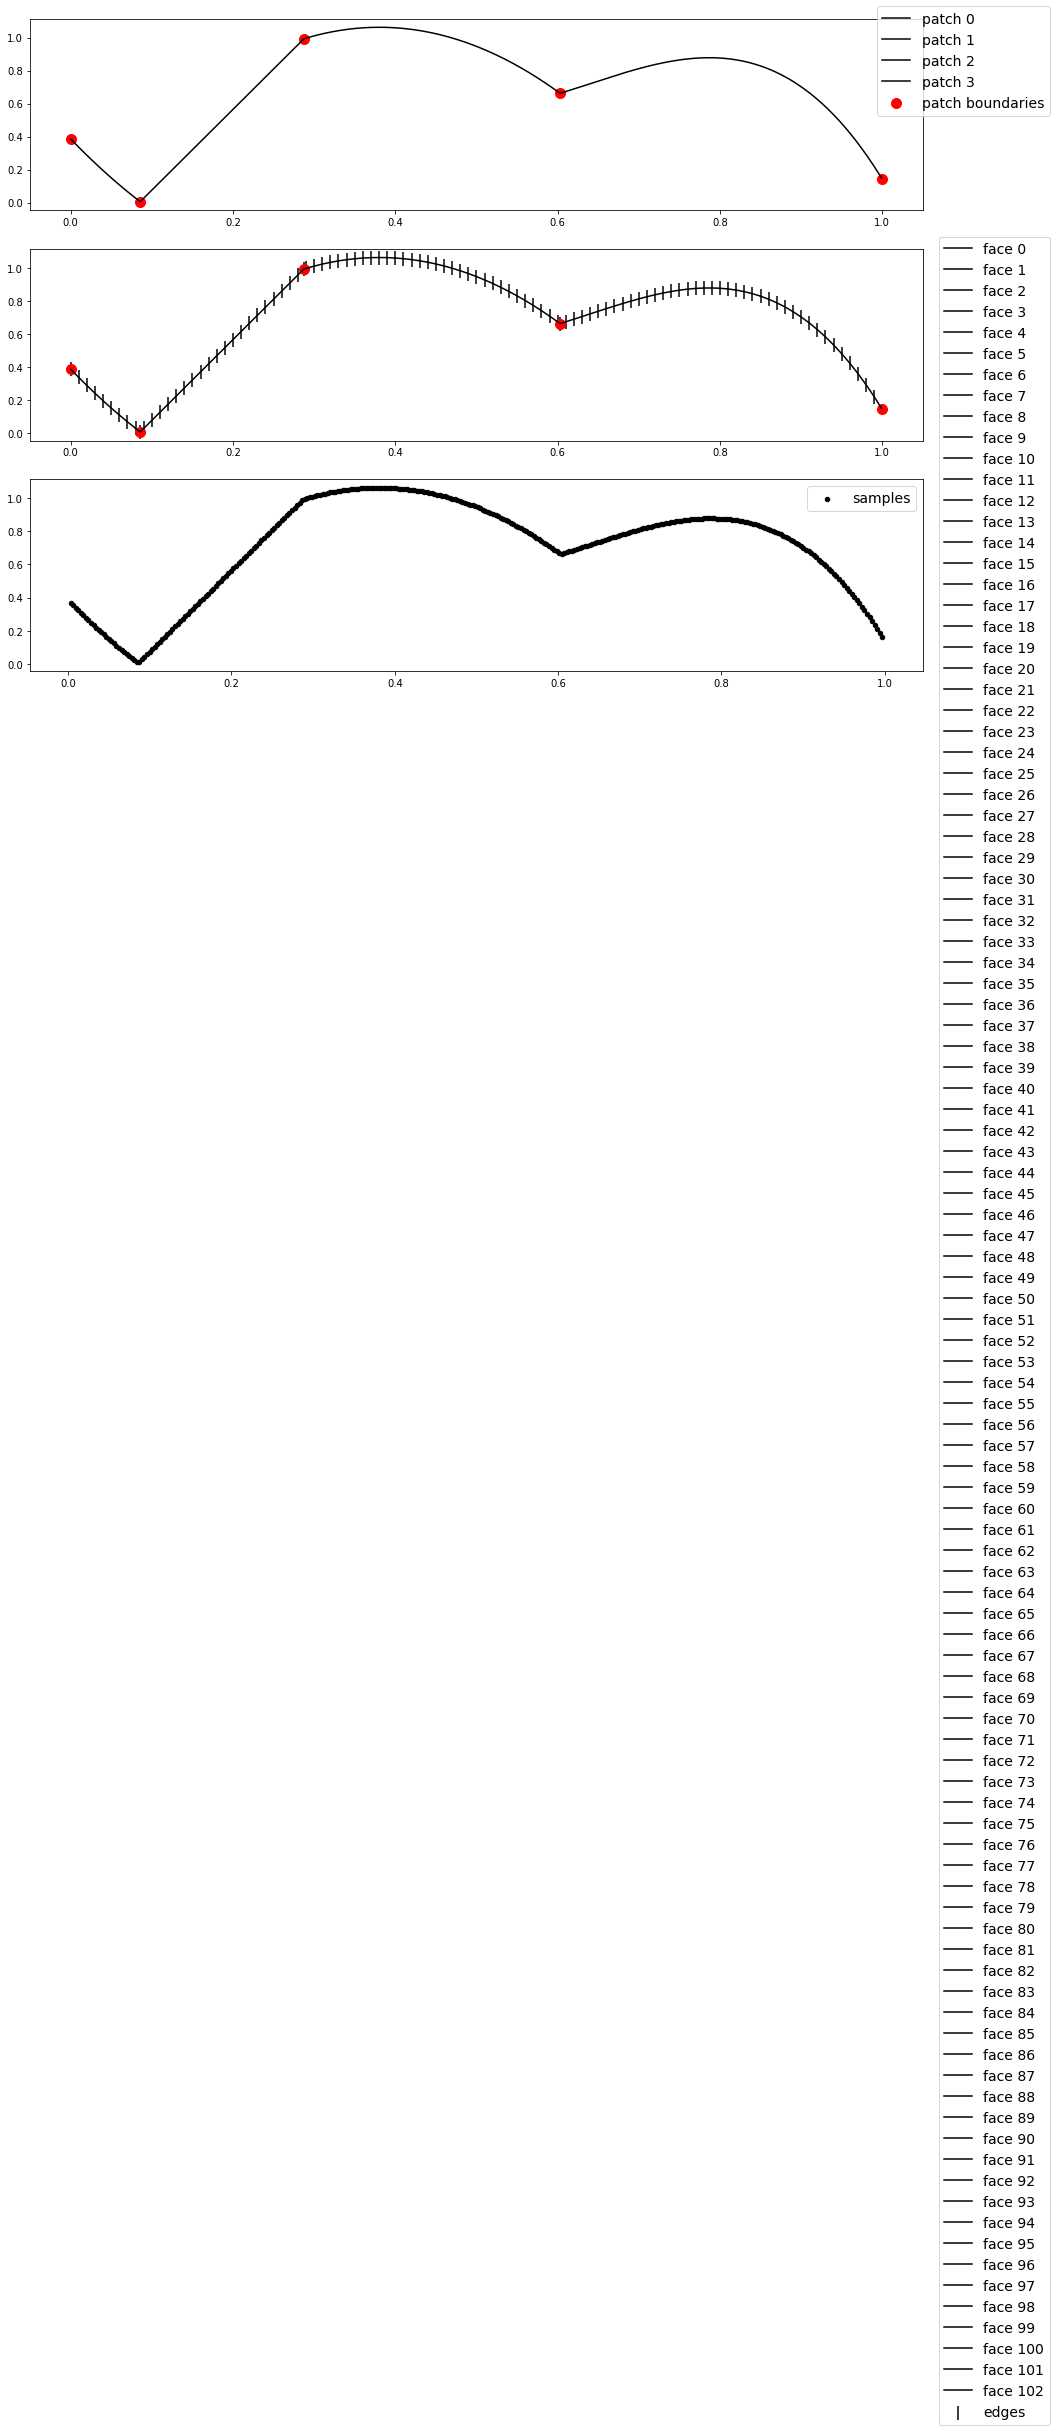

In [44]:
plot_all(
    func_values,
    x_i, y_i,
    discrete_func_values,
    discrete_x_i, discrete_y_i,
    samples_x, samples_y
)

**Requirements (user perspective):**
 * x

**Specification (system perspective)**

The used dataset shall:
 * have no undersampled surface patches (e.g., at least $n_s$ mesh vertices sampled along each boundary on each surface patch)
 * have no oversampled faces, so that phantom normal discontinuities cannot emerge (e.g., at most $n_f$ points sampled on each face)

**Architecture/design**
 * For each mesh patch:
   * _Check for undersampled surfaces._ For each surface spline patch:
     * If the surface spline patch is exactly flat, continue.
     * Check for number of edges approximating boundary: find adjacent curves belonging to the surface patch, select `n_s = min { num_len(curve) for curve in boundaries}` as number of edges on each boundary
     * Option 1: discard mesh patch when: `n_s < thr_s`
     * Option 2 (take into account sampling density): discard mesh patch when: `point_density / l_s > thr1_s` or `point_density / l_s < thr2_s` where `l_s = mean { edge_len(curve) for curve in boundaries}` as boundary length
     * Option 3: ideally consider patch curvature: TBD
     
   * _Check for poorly sampled faces._ 
     * Discard mesh patch when `num_points_per_face = num_points / num_faces_in_mesh_patch < thr1_f` or `num_points_per_face = num_points / num_faces_in_mesh_patch > thr2_f`

